# Libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg11
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:1" if (torch.cuda.is_available()) else "cpu")

# Dataset Loader

In [3]:
train_loader, valid_loader,train_loader_SI, test_loader = load_loaders('data_loaders.pkl')

100%|██████████| 170498071/170498071 [00:03<00:00, 43904992.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Functions

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda', save_filename=None):
    # Define criterion, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize variables for tracking best accuracy and corresponding model weights
    best_val_acc = 0.0
    best_model_weights = None
    early_stopping_counter = 0

    # Lists to store metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    total_step = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            running_loss += loss.item()

        # Calculate and store training accuracy and loss
        epoch_train_accuracy = 100 * correct_train / total_train
        epoch_train_loss = running_loss / len(train_loader)
        train_acc_list.append(epoch_train_accuracy)
        train_loss_list.append(epoch_train_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Validation
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            val_loss = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            # Calculate validation accuracy
            current_val_acc = 100 * correct / total

            # Store validation loss and accuracy
            val_loss_list.append(val_loss / len(valid_loader))
            val_acc_list.append(current_val_acc)

            # Check if the current accuracy is the best so far
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                # Save the model weights
                best_model_weights = model.state_dict()
                # Reset early stopping counter
                early_stopping_counter = 0
            else:
                # Increment early stopping counter
                early_stopping_counter += 1

            # Check for early stopping
            if early_stopping_counter >= early_stopping_threshold:
                print(f'Early stopping after {early_stopping_counter} epochs without improvement.')
                break

        # Print and save metrics
        print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, epoch_train_loss, epoch_train_accuracy, current_val_acc, val_loss_list[-1]))

    # Print test set accuracy on the best weights
    test_accuracy = test_model(model, test_loader, device)
    print(f'Test Set Accuracy on Best Weights: {test_accuracy:.2f}%')

    # Save the model with the best validation accuracy
    torch.save(best_model_weights, save_filename)

    # Plot training and validation metrics
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [6]:
# Print the summary with information about frozen layers
def print_trainable_status(module, prefix=""):
    for name, child in module.named_children():
        for param in child.parameters():
            print(f"{prefix}{'.'.join([module._get_name(), name])}: requires_grad={param.requires_grad}")
        print_trainable_status(child, prefix + "  ")

In [3]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 787.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [3]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# First Layer

In [6]:
import torch.nn as nn

class VGG_first_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_first_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


model = VGG_first_layer().to(device)
model

VGG_first_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:39<09:12, 39.44s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3896, Training Accuracy: 50.67%, Validation Accuracy: 52.58%, Validation Loss: 1.3352


 13%|█▎        | 2/15 [01:18<08:32, 39.39s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.3176, Training Accuracy: 53.16%, Validation Accuracy: 55.06%, Validation Loss: 1.2994


 20%|██        | 3/15 [01:58<07:52, 39.39s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.2720, Training Accuracy: 55.10%, Validation Accuracy: 55.58%, Validation Loss: 1.2744


 27%|██▋       | 4/15 [02:38<07:17, 39.73s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.2277, Training Accuracy: 57.02%, Validation Accuracy: 56.80%, Validation Loss: 1.2239


 33%|███▎      | 5/15 [03:18<06:39, 39.91s/it]

Epoch [5/15], Step [352/352], Training Loss: 1.1910, Training Accuracy: 58.24%, Validation Accuracy: 58.04%, Validation Loss: 1.2118


 40%|████      | 6/15 [03:58<05:57, 39.74s/it]

Epoch [6/15], Step [352/352], Training Loss: 1.0917, Training Accuracy: 62.21%, Validation Accuracy: 61.36%, Validation Loss: 1.1114


 47%|████▋     | 7/15 [04:37<05:17, 39.68s/it]

Epoch [7/15], Step [352/352], Training Loss: 1.0734, Training Accuracy: 62.57%, Validation Accuracy: 61.72%, Validation Loss: 1.0849


 53%|█████▎    | 8/15 [05:17<04:37, 39.69s/it]

Epoch [8/15], Step [352/352], Training Loss: 1.0632, Training Accuracy: 63.20%, Validation Accuracy: 61.46%, Validation Loss: 1.1088


 60%|██████    | 9/15 [05:56<03:57, 39.55s/it]

Epoch [9/15], Step [352/352], Training Loss: 1.0592, Training Accuracy: 63.19%, Validation Accuracy: 61.94%, Validation Loss: 1.0925


 67%|██████▋   | 10/15 [06:36<03:17, 39.55s/it]

Epoch [10/15], Step [352/352], Training Loss: 1.0518, Training Accuracy: 63.31%, Validation Accuracy: 63.08%, Validation Loss: 1.0754


 73%|███████▎  | 11/15 [07:15<02:38, 39.56s/it]

Epoch [11/15], Step [352/352], Training Loss: 1.0331, Training Accuracy: 64.19%, Validation Accuracy: 62.02%, Validation Loss: 1.0788


 80%|████████  | 12/15 [07:54<01:58, 39.46s/it]

Epoch [12/15], Step [352/352], Training Loss: 1.0365, Training Accuracy: 64.04%, Validation Accuracy: 62.58%, Validation Loss: 1.0787


 87%|████████▋ | 13/15 [08:34<01:19, 39.54s/it]

Epoch [13/15], Step [352/352], Training Loss: 1.0323, Training Accuracy: 64.28%, Validation Accuracy: 62.38%, Validation Loss: 1.0888


 93%|█████████▎| 14/15 [09:15<00:40, 40.06s/it]

Epoch [14/15], Step [352/352], Training Loss: 1.0351, Training Accuracy: 64.44%, Validation Accuracy: 63.12%, Validation Loss: 1.0711


100%|██████████| 15/15 [09:55<00:00, 39.70s/it]

Epoch [15/15], Step [352/352], Training Loss: 1.0315, Training Accuracy: 64.36%, Validation Accuracy: 62.32%, Validation Loss: 1.0837


Test Set Accuracy on Best Weights: 65.12%


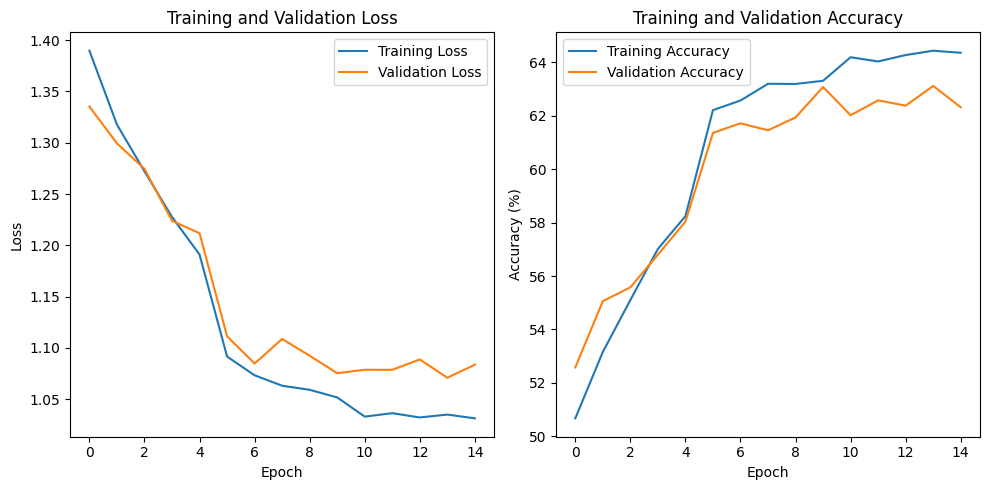

In [8]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'first_layer_freeze.pth' )

# CSI first layer - train

In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

100%|██████████| 36/36 [00:00<00:00, 117.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 390.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1612.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2941.31it/s]


[('layer1', 0.35333332419395447), ('fc1', 0.6191111207008362), ('fc2', 0.5606666803359985)]


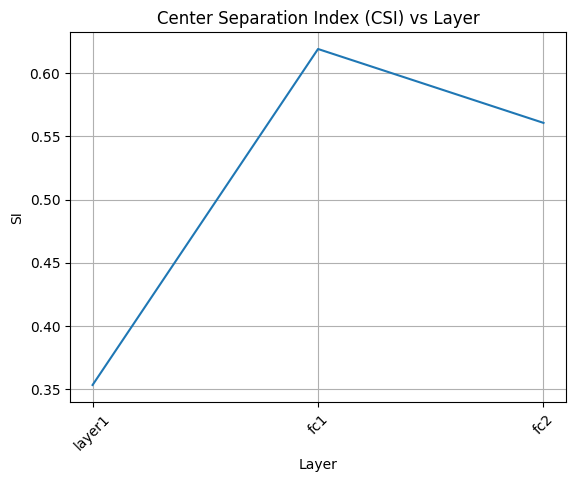

In [9]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI first layer - test

100%|██████████| 79/79 [00:01<00:00, 52.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 814.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4026.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4444.06it/s]

[('layer1', 0.3587999939918518), ('fc1', 0.6344999670982361), ('fc2', 0.5848999619483948)]


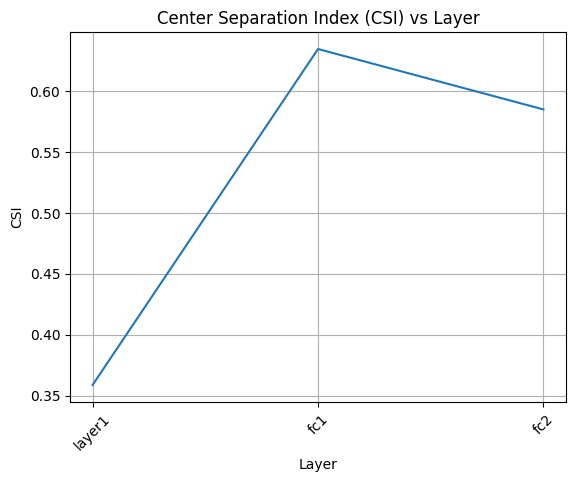

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {''}

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))
    
    
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    
    

# Second Layer

In [8]:
import torch.nn as nn

class VGG11_second_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_second_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Example usage:
from torchsummary import summary

# Initialize your model
model = VGG11_second_layer().to(device)

# Load your pretrained weights for the first layer
saved_state_dict = torch.load('first_layer_freeze.pth')

# Filter out unnecessary keys
filtered_state_dict = {k: v for k, v in saved_state_dict.items() if 'layer1' in k}

# Load the filtered state dict (only first layer weights)
model.load_state_dict(filtered_state_dict, strict=False)

# Freeze the first layer
for param in model.layer1.parameters():
    param.requires_grad = False

model

VGG11_second_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
print_trainable_status(model)

VGG11_second_layer.layer1: requires_grad=False
VGG11_second_layer.layer1: requires_grad=False
VGG11_second_layer.layer1: requires_grad=False
VGG11_second_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_second_layer.layer2: requires_grad=True
VGG11_second_layer.layer2: requires_grad=True
VGG11_second_layer.layer2: requires_grad=True
VGG11_second_layer.layer2: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.1: requires_grad=True
  Sequential.1: requires_grad=True
VGG11_second_layer.fc1: requires_grad=True
VGG11_second_layer.fc1: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.0: requires_grad=True
VGG11_second_layer.fc2: requires_grad=True
VGG11_second_layer.fc2: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.0: requires_grad=True


  7%|▋         | 1/15 [00:40<09:23, 40.25s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3644, Training Accuracy: 51.72%, Validation Accuracy: 55.40%, Validation Loss: 1.2508


 13%|█▎        | 2/15 [01:20<08:43, 40.27s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.0845, Training Accuracy: 61.50%, Validation Accuracy: 61.02%, Validation Loss: 1.0827


 20%|██        | 3/15 [02:00<08:01, 40.13s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.0195, Training Accuracy: 64.05%, Validation Accuracy: 64.26%, Validation Loss: 0.9797


 27%|██▋       | 4/15 [02:40<07:21, 40.17s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.9660, Training Accuracy: 65.90%, Validation Accuracy: 65.26%, Validation Loss: 0.9737


 33%|███▎      | 5/15 [03:21<06:43, 40.32s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.9273, Training Accuracy: 67.30%, Validation Accuracy: 62.86%, Validation Loss: 1.0439


 40%|████      | 6/15 [04:02<06:04, 40.46s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.8311, Training Accuracy: 71.42%, Validation Accuracy: 69.44%, Validation Loss: 0.8576


 47%|████▋     | 7/15 [04:42<05:22, 40.35s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.8075, Training Accuracy: 72.20%, Validation Accuracy: 70.02%, Validation Loss: 0.8469


 53%|█████▎    | 8/15 [05:22<04:43, 40.48s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.7942, Training Accuracy: 72.59%, Validation Accuracy: 70.32%, Validation Loss: 0.8301


 60%|██████    | 9/15 [06:03<04:02, 40.36s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.7915, Training Accuracy: 72.48%, Validation Accuracy: 70.24%, Validation Loss: 0.8423


 67%|██████▋   | 10/15 [06:43<03:21, 40.38s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.7855, Training Accuracy: 72.94%, Validation Accuracy: 70.58%, Validation Loss: 0.8539


 73%|███████▎  | 11/15 [07:23<02:41, 40.29s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.7654, Training Accuracy: 73.60%, Validation Accuracy: 71.08%, Validation Loss: 0.8345


 80%|████████  | 12/15 [08:04<02:01, 40.38s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.7659, Training Accuracy: 73.64%, Validation Accuracy: 70.96%, Validation Loss: 0.8237


 87%|████████▋ | 13/15 [08:44<01:20, 40.36s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.7648, Training Accuracy: 73.69%, Validation Accuracy: 71.34%, Validation Loss: 0.8248


 93%|█████████▎| 14/15 [09:24<00:40, 40.36s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.7660, Training Accuracy: 73.53%, Validation Accuracy: 71.40%, Validation Loss: 0.8211


100%|██████████| 15/15 [10:04<00:00, 40.33s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.7628, Training Accuracy: 73.62%, Validation Accuracy: 71.46%, Validation Loss: 0.8140


Test Set Accuracy on Best Weights: 74.07%


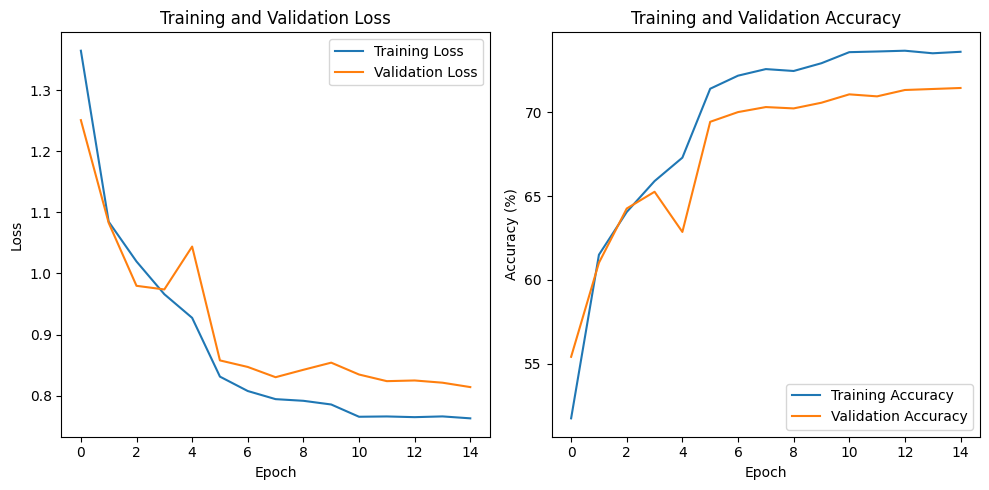

In [10]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'second_layer_freeze.pth' )

# CSI second layer - train

100%|██████████| 36/36 [00:00<00:00, 421.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2263.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2922.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1702.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3241.35it/s]

[('layer1', 0.35333332419395447), ('layer2', 0.5226666927337646), ('fc1', 0.7155555486679077), ('fc2', 0.6688888669013977)]


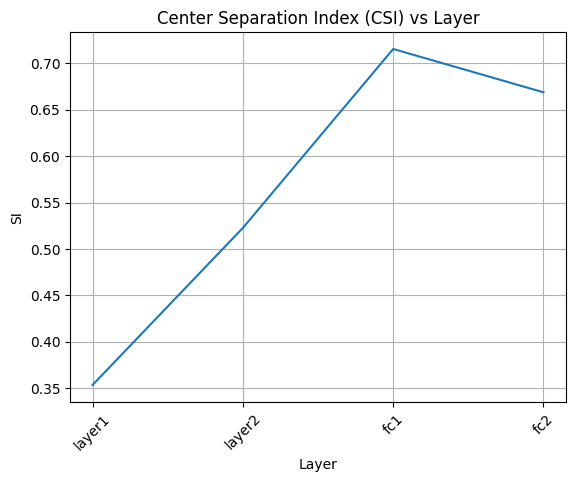

In [12]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.35333332419395447), ('layer2', 0.5226666927337646), ('fc1', 0.7155555486679077), ('fc2', 0.6688888669013977)]


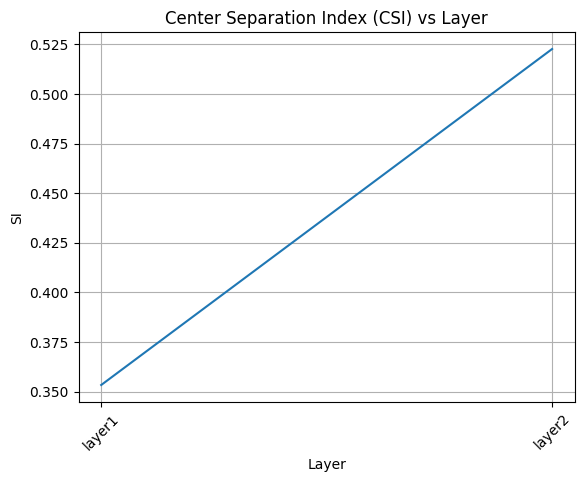

In [13]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI second layer - test

100%|██████████| 36/36 [00:00<00:00, 208.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2132.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2591.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1727.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3278.51it/s]

[('layer1', 0.3324444591999054), ('layer2', 0.518666684627533), ('fc1', 0.7088888883590698), ('fc2', 0.6655555367469788)]


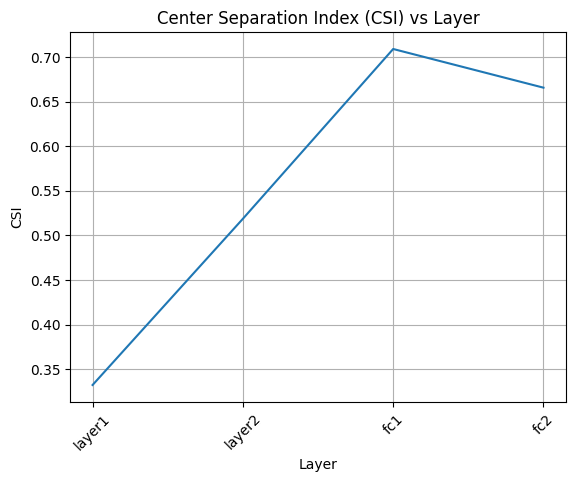

[('layer1', 0.3324444591999054), ('layer2', 0.518666684627533), ('fc1', 0.7088888883590698), ('fc2', 0.6655555367469788)]


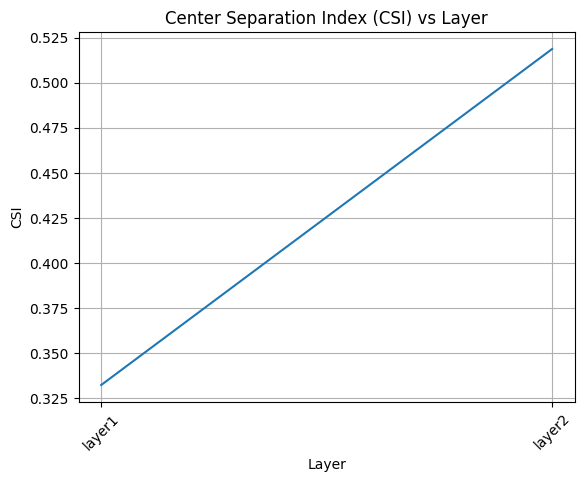

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()  

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Third Layer

In [11]:
import torch.nn as nn

class VGG11_third_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_third_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [12]:
import torch
import torch.nn as nn

# Initialize your model
model = VGG11_third_layer().to(device)

# Load the pretrained weights for the first layer
pretrained_dict1 = torch.load('first_layer_freeze.pth')
model_dict = model.state_dict()

# Filter and update the state dict for the first layer
pretrained_dict1 = {k: v for k, v in pretrained_dict1.items() if k in model_dict and 'layer2' not in k and 'layer3' not in k and 'fc1' not in k and 'fc2' not in k}
model_dict.update(pretrained_dict1)

# Load the pretrained weights for the second layer
pretrained_dict2 = torch.load('second_layer_freeze.pth')

# Filter and update the state dict for the second layer
pretrained_dict2 = {k: v for k, v in pretrained_dict2.items() if k in model_dict and 'layer3' not in k and 'fc1' not in k and 'fc2' not in k}
model_dict.update(pretrained_dict2)

# Load the new state dict into the model
model.load_state_dict(model_dict)

# Freeze the first and second layers
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False

model

VGG11_third_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [13]:
print_trainable_status(model)

VGG11_third_layer.layer1: requires_grad=False
VGG11_third_layer.layer1: requires_grad=False
VGG11_third_layer.layer1: requires_grad=False
VGG11_third_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_third_layer.layer2: requires_grad=False
VGG11_third_layer.layer2: requires_grad=False
VGG11_third_layer.layer2: requires_grad=False
VGG11_third_layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_third_layer.layer3: requires_grad=True
VGG11_third_layer.layer3: requires_grad=True
VGG11_third_layer.layer3: requires_grad=True
VGG11_third_layer.layer3: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.0: requires_grad=True
  Sequential.1: requires_grad=True
  Sequential.1: requires_grad=True
VGG11_third_layer.fc1: r

  7%|▋         | 1/15 [00:40<09:20, 40.06s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.0300, Training Accuracy: 63.96%, Validation Accuracy: 68.32%, Validation Loss: 0.8807


 13%|█▎        | 2/15 [01:24<09:15, 42.71s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.8364, Training Accuracy: 70.94%, Validation Accuracy: 71.60%, Validation Loss: 0.8204


 20%|██        | 3/15 [02:05<08:20, 41.74s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7654, Training Accuracy: 73.09%, Validation Accuracy: 74.28%, Validation Loss: 0.7581


 27%|██▋       | 4/15 [02:44<07:29, 40.87s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7301, Training Accuracy: 74.33%, Validation Accuracy: 73.60%, Validation Loss: 0.7549


 33%|███▎      | 5/15 [03:24<06:46, 40.64s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.6931, Training Accuracy: 75.87%, Validation Accuracy: 74.60%, Validation Loss: 0.7602


 40%|████      | 6/15 [04:07<06:10, 41.14s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.5837, Training Accuracy: 79.64%, Validation Accuracy: 77.60%, Validation Loss: 0.6569


 47%|████▋     | 7/15 [04:46<05:25, 40.69s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.5577, Training Accuracy: 80.46%, Validation Accuracy: 77.40%, Validation Loss: 0.6446


 53%|█████▎    | 8/15 [05:26<04:43, 40.46s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.5457, Training Accuracy: 80.84%, Validation Accuracy: 78.40%, Validation Loss: 0.6403


 60%|██████    | 9/15 [06:06<04:01, 40.31s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.5358, Training Accuracy: 81.13%, Validation Accuracy: 77.14%, Validation Loss: 0.6394


 67%|██████▋   | 10/15 [06:46<03:21, 40.21s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.5277, Training Accuracy: 81.61%, Validation Accuracy: 78.32%, Validation Loss: 0.6365


 73%|███████▎  | 11/15 [07:27<02:40, 40.21s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.5122, Training Accuracy: 82.16%, Validation Accuracy: 77.72%, Validation Loss: 0.6320


 80%|████████  | 12/15 [08:07<02:00, 40.15s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.5113, Training Accuracy: 82.30%, Validation Accuracy: 77.82%, Validation Loss: 0.6422


 87%|████████▋ | 13/15 [08:47<01:20, 40.27s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.5101, Training Accuracy: 82.21%, Validation Accuracy: 78.48%, Validation Loss: 0.6116


 93%|█████████▎| 14/15 [09:27<00:40, 40.25s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.5067, Training Accuracy: 82.44%, Validation Accuracy: 77.70%, Validation Loss: 0.6324


100%|██████████| 15/15 [10:08<00:00, 40.55s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.5076, Training Accuracy: 82.50%, Validation Accuracy: 77.96%, Validation Loss: 0.6281


Test Set Accuracy on Best Weights: 79.97%


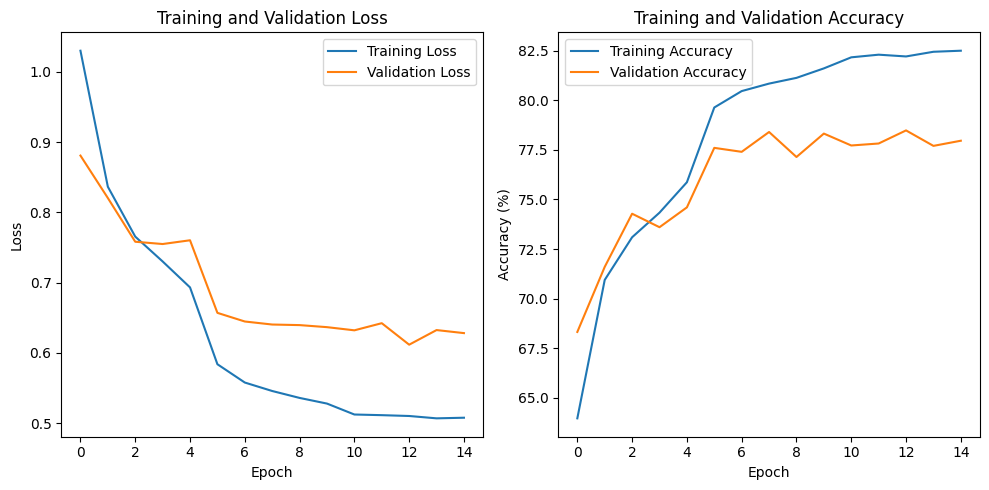

In [14]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'third_layer_freeze.pth' )

# CSI third layer - train

100%|██████████| 36/36 [00:00<00:00, 240.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2170.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3066.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2109.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1586.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3134.76it/s]

[('layer1', 0.35288888216018677), ('layer2', 0.5224444270133972), ('layer3', 0.6315555572509766), ('fc1', 0.808222234249115), ('fc2', 0.7657777667045593)]


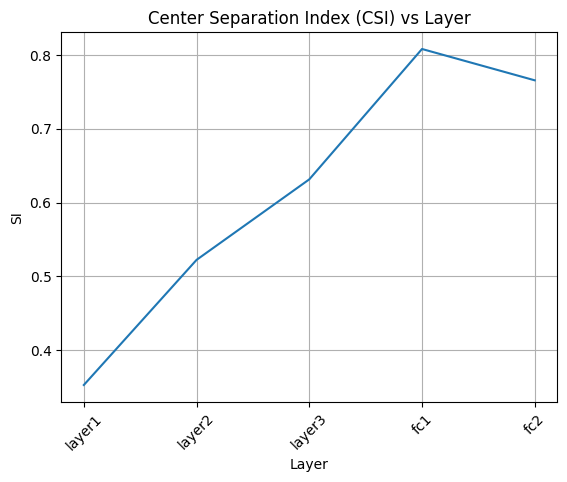

In [17]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.35288888216018677), ('layer2', 0.5224444270133972), ('layer3', 0.6315555572509766), ('fc1', 0.808222234249115), ('fc2', 0.7657777667045593)]


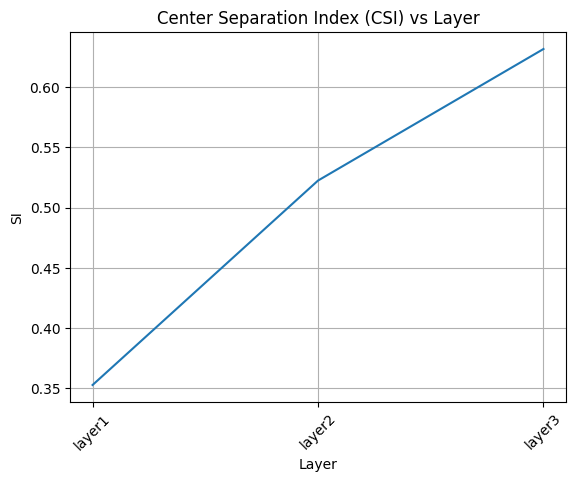

In [18]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI third layer - test

100%|██████████| 79/79 [00:01<00:00, 60.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3367.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4164.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3162.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4232.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4797.88it/s]


[('layer1', 0.35979998111724854), ('layer2', 0.530299961566925), ('layer3', 0.6416999697685242), ('fc1', 0.7888000011444092), ('fc2', 0.7524999976158142)]


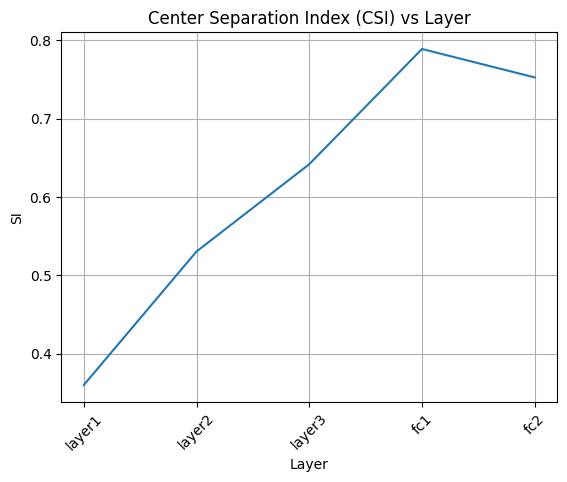

[('layer1', 0.35979998111724854), ('layer2', 0.530299961566925), ('layer3', 0.6416999697685242), ('fc1', 0.7888000011444092), ('fc2', 0.7524999976158142)]


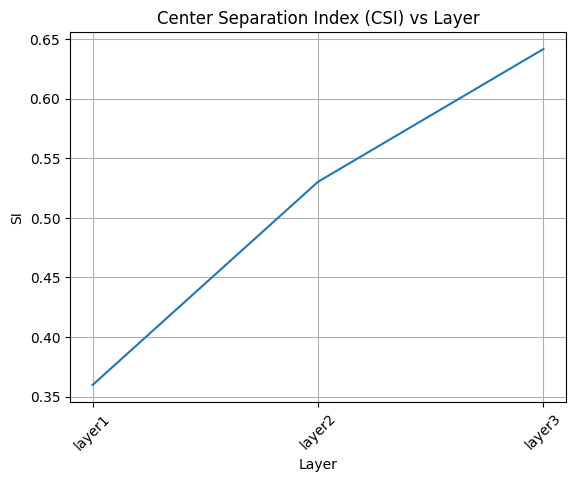

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer

In [14]:
import torch.nn as nn

class VGG11_Fourth_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_Fourth_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
import torch
import torch.nn as nn

# Initialize your model
model = VGG11_Fourth_Layer().to(device)

# Define the paths to your weight files
weight_files = {
    'layer1': 'first_layer_freeze.pth',
    'layer2': 'second_layer_freeze.pth',
    'layer3': 'third_layer_freeze.pth'
}

# Load and update the model's state dict for each layer
for layer_name, file_path in weight_files.items():
    pretrained_dict = torch.load(file_path)
    model_dict = model.state_dict()
    # Filter out FC layer weights and update the state dict for each layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)

# Freeze the first three layers
for layer in [model.layer1, model.layer2, model.layer3]:
    for param in layer.parameters():
        param.requires_grad = False

model

VGG11_Fourth_Layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [17]:
print_trainable_status(model)

VGG11_Fourth_Layer.layer1: requires_grad=False
VGG11_Fourth_Layer.layer1: requires_grad=False
VGG11_Fourth_Layer.layer1: requires_grad=False
VGG11_Fourth_Layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_Fourth_Layer.layer2: requires_grad=False
VGG11_Fourth_Layer.layer2: requires_grad=False
VGG11_Fourth_Layer.layer2: requires_grad=False
VGG11_Fourth_Layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_Fourth_Layer.layer3: requires_grad=False
VGG11_Fourth_Layer.layer3: requires_grad=False
VGG11_Fourth_Layer.layer3: requires_grad=False
VGG11_Fourth_Layer.layer3: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG1

  7%|▋         | 1/15 [00:40<09:21, 40.13s/it]

Epoch [1/15], Step [352/352], Training Loss: 0.8381, Training Accuracy: 70.47%, Validation Accuracy: 74.68%, Validation Loss: 0.7155


 13%|█▎        | 2/15 [01:20<08:43, 40.27s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.6562, Training Accuracy: 77.07%, Validation Accuracy: 75.78%, Validation Loss: 0.6857


 20%|██        | 3/15 [02:00<08:01, 40.12s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.6147, Training Accuracy: 78.43%, Validation Accuracy: 75.70%, Validation Loss: 0.7106


 27%|██▋       | 4/15 [02:40<07:20, 40.03s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.5913, Training Accuracy: 79.31%, Validation Accuracy: 76.92%, Validation Loss: 0.6641


 33%|███▎      | 5/15 [03:20<06:40, 40.07s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.5526, Training Accuracy: 80.50%, Validation Accuracy: 78.18%, Validation Loss: 0.6256


 40%|████      | 6/15 [04:00<06:01, 40.16s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.4704, Training Accuracy: 83.62%, Validation Accuracy: 80.28%, Validation Loss: 0.5819


 47%|████▋     | 7/15 [04:41<05:21, 40.18s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.4486, Training Accuracy: 84.26%, Validation Accuracy: 80.00%, Validation Loss: 0.5911


 53%|█████▎    | 8/15 [05:21<04:42, 40.39s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4442, Training Accuracy: 84.52%, Validation Accuracy: 79.36%, Validation Loss: 0.5868


 60%|██████    | 9/15 [06:01<04:01, 40.30s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.4353, Training Accuracy: 84.83%, Validation Accuracy: 80.46%, Validation Loss: 0.5969


 67%|██████▋   | 10/15 [06:42<03:21, 40.28s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.4261, Training Accuracy: 85.03%, Validation Accuracy: 80.02%, Validation Loss: 0.5617


 73%|███████▎  | 11/15 [07:22<02:41, 40.29s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.4176, Training Accuracy: 85.49%, Validation Accuracy: 79.86%, Validation Loss: 0.5714


 80%|████████  | 12/15 [08:04<02:02, 40.72s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.4183, Training Accuracy: 85.37%, Validation Accuracy: 80.26%, Validation Loss: 0.5695


 87%|████████▋ | 13/15 [08:44<01:21, 40.58s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.4121, Training Accuracy: 85.52%, Validation Accuracy: 80.24%, Validation Loss: 0.5741


 93%|█████████▎| 14/15 [09:25<00:40, 40.68s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.4148, Training Accuracy: 85.52%, Validation Accuracy: 80.72%, Validation Loss: 0.5558


100%|██████████| 15/15 [10:05<00:00, 40.38s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.4128, Training Accuracy: 85.48%, Validation Accuracy: 80.42%, Validation Loss: 0.5477


Test Set Accuracy on Best Weights: 82.58%


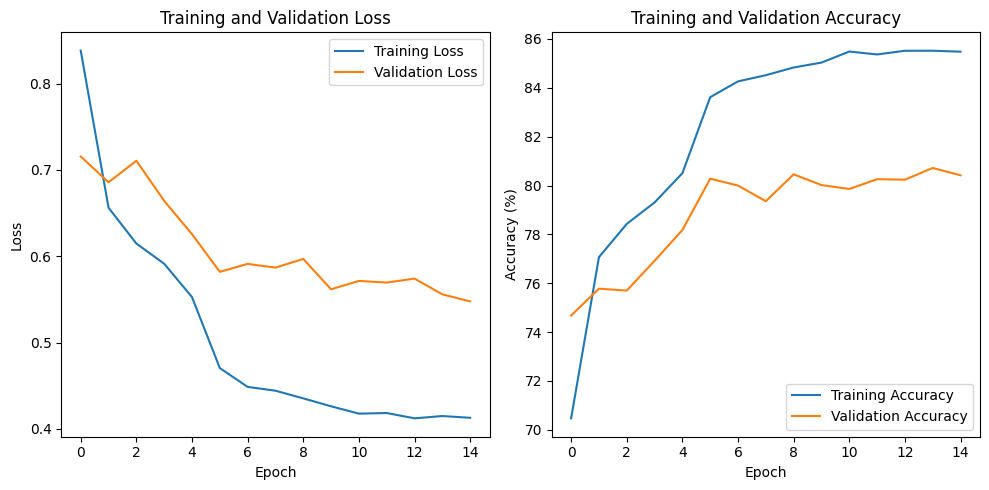

In [18]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'fourth_layer_freeze.pth' )

# Fourth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 251.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2654.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3029.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3026.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3491.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3096.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3255.60it/s]


[('layer1', 0.3535555601119995), ('layer2', 0.5228888988494873), ('layer3', 0.6322222352027893), ('layer4', 0.7317777872085571), ('fc1', 0.8404444456100464), ('fc2', 0.8073333501815796)]


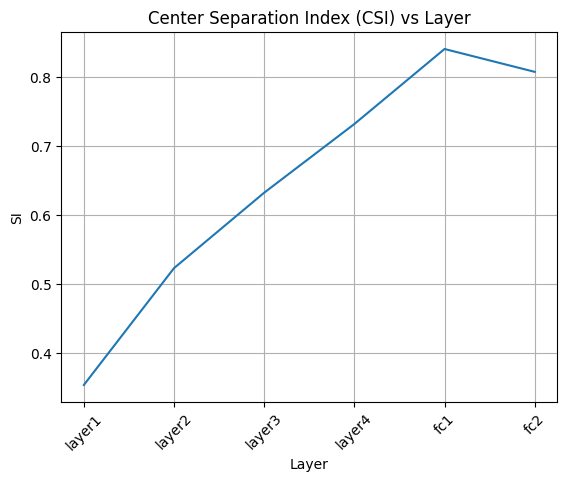

In [22]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.3535555601119995), ('layer2', 0.5228888988494873), ('layer3', 0.6322222352027893), ('layer4', 0.7317777872085571), ('fc1', 0.8404444456100464), ('fc2', 0.8073333501815796)]


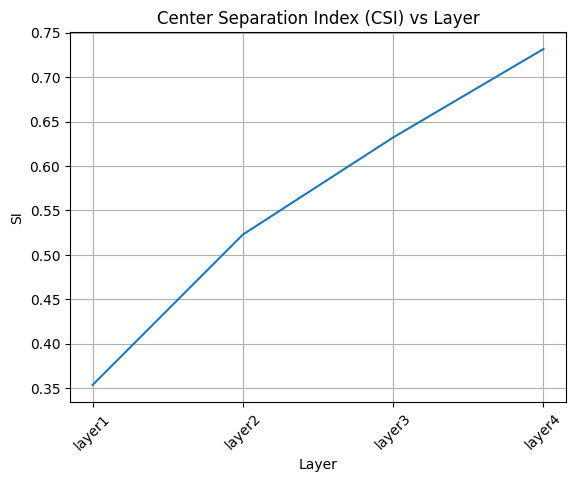

In [23]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 58.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4066.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4320.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4144.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4331.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3940.53it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4398.39it/s]

[('layer1', 0.3601999878883362), ('layer2', 0.5295000076293945), ('layer3', 0.640500009059906), ('layer4', 0.7272999882698059), ('fc1', 0.8144999742507935), ('fc2', 0.7813000082969666)]


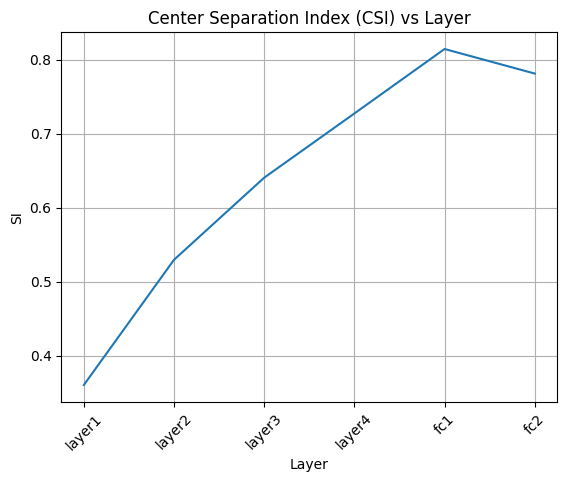

[('layer1', 0.3601999878883362), ('layer2', 0.5295000076293945), ('layer3', 0.640500009059906), ('layer4', 0.7272999882698059), ('fc1', 0.8144999742507935), ('fc2', 0.7813000082969666)]


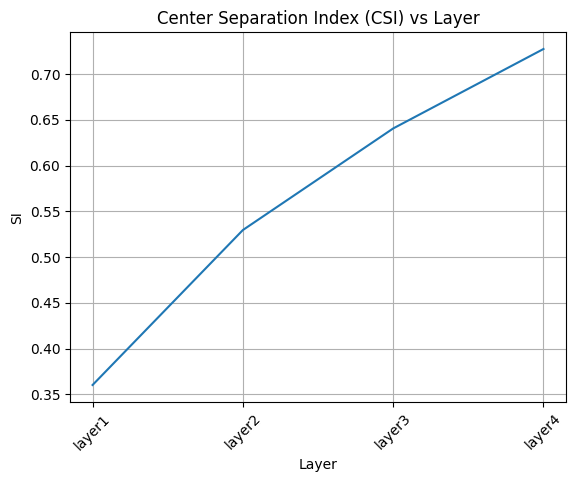

In [20]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer

In [17]:
import torch.nn as nn

class VGG11_fifth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_fifth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [18]:
import torch
import torch.nn as nn


model = VGG11_fifth_layer().to(device)

# Define the paths to your weight files
weight_files = {
    'layer1': 'first_layer_freeze.pth',
    'layer2': 'second_layer_freeze.pth',
    'layer3': 'third_layer_freeze.pth',
    'layer4': 'fourth_layer_freeze.pth'

}

# Load and update the model's state dict for each layer
for layer_name, file_path in weight_files.items():
    pretrained_dict = torch.load(file_path)
    model_dict = model.state_dict()
    # Filter out FC layer weights and update the state dict for each layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)

# Freeze the first three layers
for layer in [model.layer1, model.layer2, model.layer3, model.layer4]:
    for param in layer.parameters():
        param.requires_grad = False
model

VGG11_fifth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [26]:
print_trainable_status(model)

VGG11_fifth_layer.layer1: requires_grad=False
VGG11_fifth_layer.layer1: requires_grad=False
VGG11_fifth_layer.layer1: requires_grad=False
VGG11_fifth_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_fifth_layer.layer2: requires_grad=False
VGG11_fifth_layer.layer2: requires_grad=False
VGG11_fifth_layer.layer2: requires_grad=False
VGG11_fifth_layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_fifth_layer.layer3: requires_grad=False
VGG11_fifth_layer.layer3: requires_grad=False
VGG11_fifth_layer.layer3: requires_grad=False
VGG11_fifth_layer.layer3: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_fifth_laye

  7%|▋         | 1/15 [00:39<09:17, 39.81s/it]

Epoch [1/15], Step [352/352], Training Loss: 0.6308, Training Accuracy: 77.94%, Validation Accuracy: 77.64%, Validation Loss: 0.6409


 13%|█▎        | 2/15 [01:20<08:41, 40.13s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.5153, Training Accuracy: 81.84%, Validation Accuracy: 78.52%, Validation Loss: 0.6240


 20%|██        | 3/15 [02:00<08:00, 40.01s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.4807, Training Accuracy: 83.10%, Validation Accuracy: 78.78%, Validation Loss: 0.6145


 27%|██▋       | 4/15 [02:40<07:20, 40.06s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.4566, Training Accuracy: 83.85%, Validation Accuracy: 79.34%, Validation Loss: 0.6029


 33%|███▎      | 5/15 [03:20<06:40, 40.03s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.4377, Training Accuracy: 84.70%, Validation Accuracy: 80.02%, Validation Loss: 0.6070


 40%|████      | 6/15 [04:01<06:04, 40.47s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3778, Training Accuracy: 86.78%, Validation Accuracy: 80.44%, Validation Loss: 0.5613


 47%|████▋     | 7/15 [04:41<05:22, 40.33s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3629, Training Accuracy: 87.33%, Validation Accuracy: 81.46%, Validation Loss: 0.5574


 53%|█████▎    | 8/15 [05:21<04:41, 40.21s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.3530, Training Accuracy: 87.61%, Validation Accuracy: 80.84%, Validation Loss: 0.5753


 60%|██████    | 9/15 [06:01<04:01, 40.18s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.3465, Training Accuracy: 87.86%, Validation Accuracy: 81.22%, Validation Loss: 0.5302


 67%|██████▋   | 10/15 [06:41<03:20, 40.14s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.3413, Training Accuracy: 87.97%, Validation Accuracy: 80.90%, Validation Loss: 0.5788


 73%|███████▎  | 11/15 [07:21<02:40, 40.10s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.3367, Training Accuracy: 88.18%, Validation Accuracy: 81.60%, Validation Loss: 0.5458


 80%|████████  | 12/15 [08:01<02:00, 40.10s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.3365, Training Accuracy: 88.22%, Validation Accuracy: 81.08%, Validation Loss: 0.5897


 87%|████████▋ | 13/15 [08:41<01:19, 39.97s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.3358, Training Accuracy: 88.32%, Validation Accuracy: 81.48%, Validation Loss: 0.5630


 93%|█████████▎| 14/15 [09:21<00:39, 39.89s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.3340, Training Accuracy: 88.29%, Validation Accuracy: 80.98%, Validation Loss: 0.5471


100%|██████████| 15/15 [10:01<00:00, 40.08s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.3347, Training Accuracy: 88.11%, Validation Accuracy: 80.70%, Validation Loss: 0.5676


Test Set Accuracy on Best Weights: 82.99%


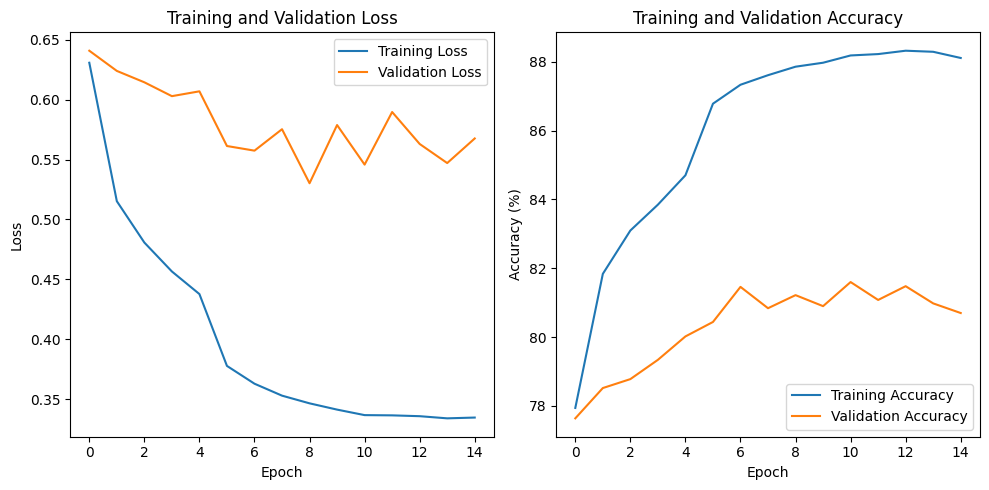

In [27]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'fifth_layer_freeze.pth' )

# Fifth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 205.92it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2672.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2916.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2949.58it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2920.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2889.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2155.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2929.67it/s]

[('layer1', 0.3535555601119995), ('layer2', 0.5251111388206482), ('layer3', 0.6333333253860474), ('layer4', 0.7315555810928345), ('layer5', 0.7942222356796265), ('fc1', 0.8713333606719971), ('fc2', 0.8384444713592529)]


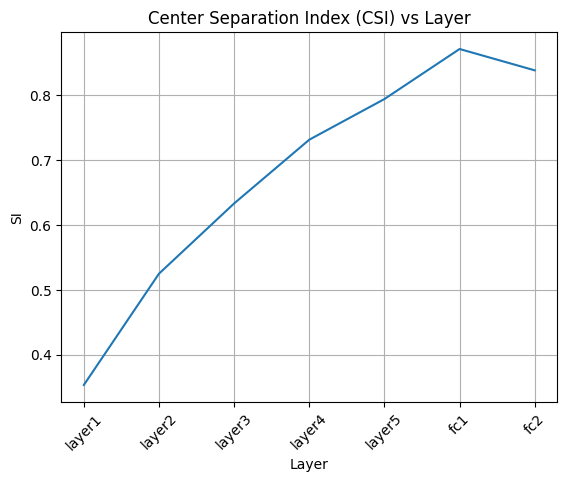

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.3535555601119995), ('layer2', 0.5251111388206482), ('layer3', 0.6333333253860474), ('layer4', 0.7315555810928345), ('layer5', 0.7942222356796265), ('fc1', 0.8713333606719971), ('fc2', 0.8384444713592529)]


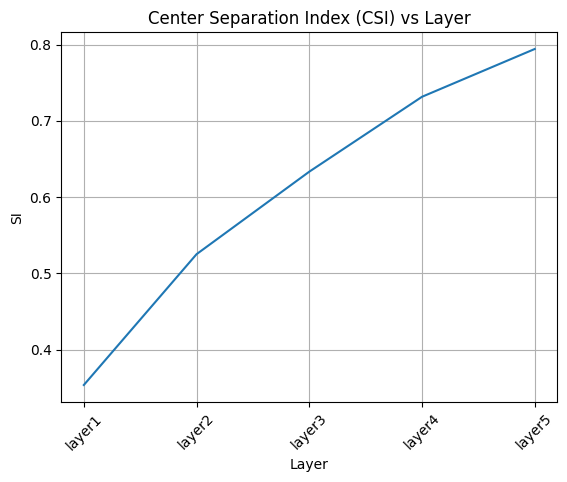

In [27]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 57.79it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4205.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4377.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4080.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4215.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4673.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4208.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4276.41it/s]

[('layer1', 0.35999998450279236), ('layer2', 0.5309000015258789), ('layer3', 0.6417999863624573), ('layer4', 0.7277999520301819), ('layer5', 0.7831999659538269), ('fc1', 0.8172999620437622), ('fc2', 0.7914999723434448)]


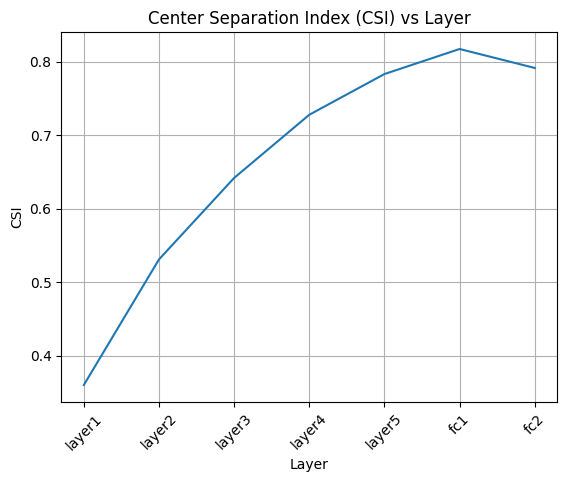

[('layer1', 0.35999998450279236), ('layer2', 0.5309000015258789), ('layer3', 0.6417999863624573), ('layer4', 0.7277999520301819), ('layer5', 0.7831999659538269), ('fc1', 0.8172999620437622), ('fc2', 0.7914999723434448)]


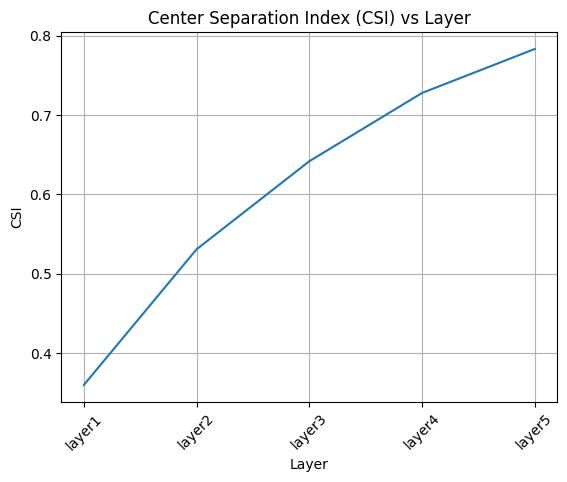

In [19]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer

In [21]:
import torch.nn as nn

class VGG11_sixth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_sixth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2* 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [22]:
import torch
import torch.nn as nn


model = VGG11_sixth_layer().to(device)

# Define the paths to your weight files
weight_files = {
    'layer1': 'first_layer_freeze.pth',
    'layer2': 'second_layer_freeze.pth',
    'layer3': 'third_layer_freeze.pth',
    'layer4': 'fourth_layer_freeze.pth',
    'layer5': 'fifth_layer_freeze.pth'


}

# Load and update the model's state dict for each layer
for layer_name, file_path in weight_files.items():
    pretrained_dict = torch.load(file_path)
    model_dict = model.state_dict()
    # Filter out FC layer weights and update the state dict for each layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)

# Freeze the first three layers
for layer in [model.layer1, model.layer2, model.layer3, model.layer4, model.layer5]:
    for param in layer.parameters():
        param.requires_grad = False

model

VGG11_sixth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [30]:
print_trainable_status(model)

VGG11_sixth_layer.layer1: requires_grad=False
VGG11_sixth_layer.layer1: requires_grad=False
VGG11_sixth_layer.layer1: requires_grad=False
VGG11_sixth_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_sixth_layer.layer2: requires_grad=False
VGG11_sixth_layer.layer2: requires_grad=False
VGG11_sixth_layer.layer2: requires_grad=False
VGG11_sixth_layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_sixth_layer.layer3: requires_grad=False
VGG11_sixth_layer.layer3: requires_grad=False
VGG11_sixth_layer.layer3: requires_grad=False
VGG11_sixth_layer.layer3: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_sixth_laye

  7%|▋         | 1/15 [00:39<09:18, 39.89s/it]

Epoch [1/15], Step [352/352], Training Loss: 0.5206, Training Accuracy: 81.88%, Validation Accuracy: 78.62%, Validation Loss: 0.6285


 13%|█▎        | 2/15 [01:20<08:40, 40.06s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.4214, Training Accuracy: 85.17%, Validation Accuracy: 79.88%, Validation Loss: 0.6141


 20%|██        | 3/15 [02:01<08:06, 40.53s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.3913, Training Accuracy: 86.25%, Validation Accuracy: 79.16%, Validation Loss: 0.6285


 27%|██▋       | 4/15 [02:41<07:24, 40.44s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.3737, Training Accuracy: 86.90%, Validation Accuracy: 81.12%, Validation Loss: 0.5751


 33%|███▎      | 5/15 [03:21<06:43, 40.30s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.3600, Training Accuracy: 87.39%, Validation Accuracy: 80.22%, Validation Loss: 0.5861


 40%|████      | 6/15 [04:01<06:01, 40.19s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3145, Training Accuracy: 88.95%, Validation Accuracy: 80.90%, Validation Loss: 0.5668


 47%|████▋     | 7/15 [04:41<05:20, 40.08s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3013, Training Accuracy: 89.42%, Validation Accuracy: 81.52%, Validation Loss: 0.5677


 53%|█████▎    | 8/15 [05:21<04:39, 39.96s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2969, Training Accuracy: 89.62%, Validation Accuracy: 81.66%, Validation Loss: 0.5530


 60%|██████    | 9/15 [06:01<04:01, 40.19s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2972, Training Accuracy: 89.51%, Validation Accuracy: 81.28%, Validation Loss: 0.5501


 67%|██████▋   | 10/15 [06:41<03:20, 40.11s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.2886, Training Accuracy: 89.79%, Validation Accuracy: 81.44%, Validation Loss: 0.6091


 73%|███████▎  | 11/15 [07:21<02:40, 40.16s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2880, Training Accuracy: 89.95%, Validation Accuracy: 81.48%, Validation Loss: 0.5901


 80%|████████  | 12/15 [08:02<02:00, 40.14s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2806, Training Accuracy: 90.23%, Validation Accuracy: 81.34%, Validation Loss: 0.5839


 87%|████████▋ | 13/15 [08:42<01:20, 40.10s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2851, Training Accuracy: 90.05%, Validation Accuracy: 81.36%, Validation Loss: 0.5867


 93%|█████████▎| 14/15 [09:21<00:39, 39.98s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2808, Training Accuracy: 90.14%, Validation Accuracy: 81.74%, Validation Loss: 0.5612


100%|██████████| 15/15 [10:01<00:00, 40.13s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2786, Training Accuracy: 90.20%, Validation Accuracy: 82.10%, Validation Loss: 0.5674


Test Set Accuracy on Best Weights: 83.17%


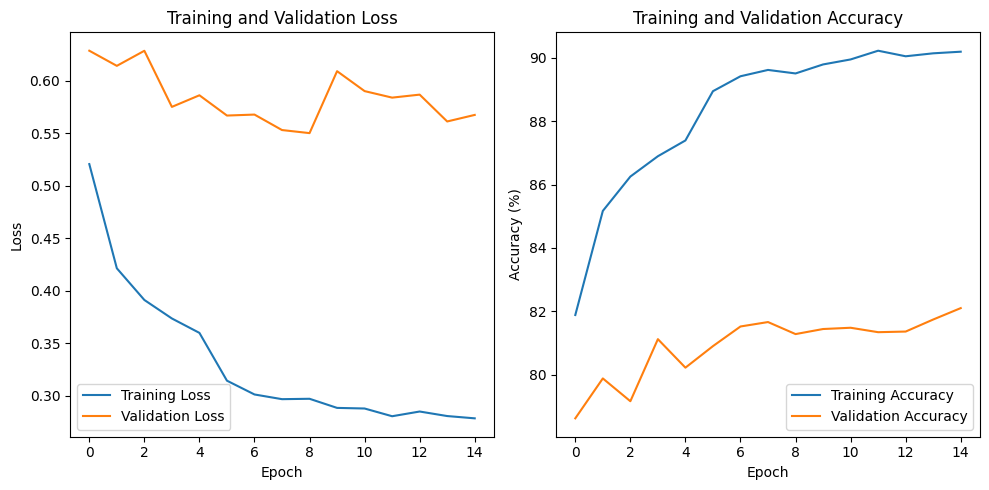

In [31]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'sixth_layer_freeze.pth' )

# Sixth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 196.41it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2814.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2761.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2957.90it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3152.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2948.89it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2816.23it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1770.00it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2890.63it/s]


[('layer1', 0.35333332419395447), ('layer2', 0.5251111388206482), ('layer3', 0.6320000290870667), ('layer4', 0.7311111092567444), ('layer5', 0.7937777638435364), ('layer6', 0.8233333230018616), ('fc1', 0.8855555653572083), ('fc2', 0.8579999804496765)]


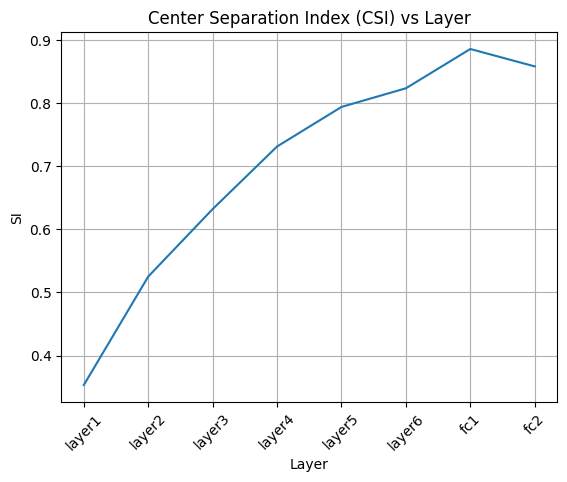

In [30]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.35333332419395447), ('layer2', 0.5251111388206482), ('layer3', 0.6320000290870667), ('layer4', 0.7311111092567444), ('layer5', 0.7937777638435364), ('layer6', 0.8233333230018616), ('fc1', 0.8855555653572083), ('fc2', 0.8579999804496765)]


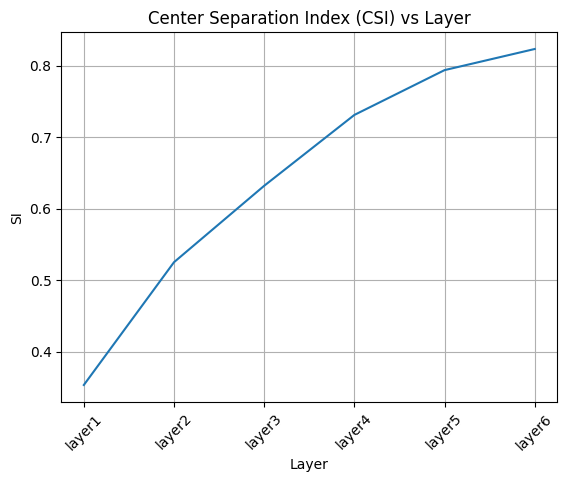

In [31]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 56.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4127.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4122.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4127.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4034.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4368.16it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4168.46it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4398.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4431.85it/s]


[('layer1', 0.3587999939918518), ('layer2', 0.5300999879837036), ('layer3', 0.6410999894142151), ('layer4', 0.7275999784469604), ('layer5', 0.7818999886512756), ('layer6', 0.786300003528595), ('fc1', 0.818399965763092), ('fc2', 0.8035999536514282)]


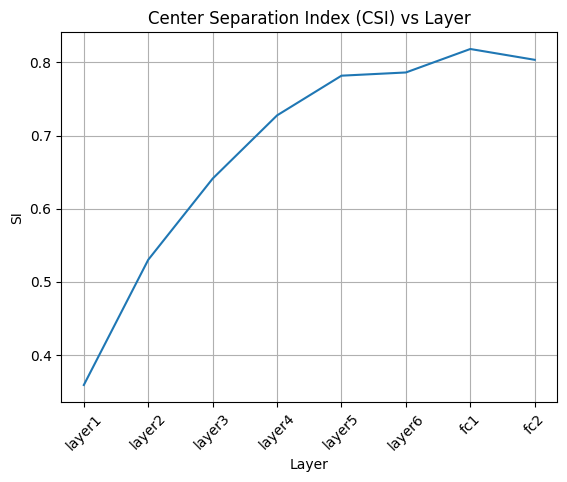

[('layer1', 0.3587999939918518), ('layer2', 0.5300999879837036), ('layer3', 0.6410999894142151), ('layer4', 0.7275999784469604), ('layer5', 0.7818999886512756), ('layer6', 0.786300003528595), ('fc1', 0.818399965763092), ('fc2', 0.8035999536514282)]


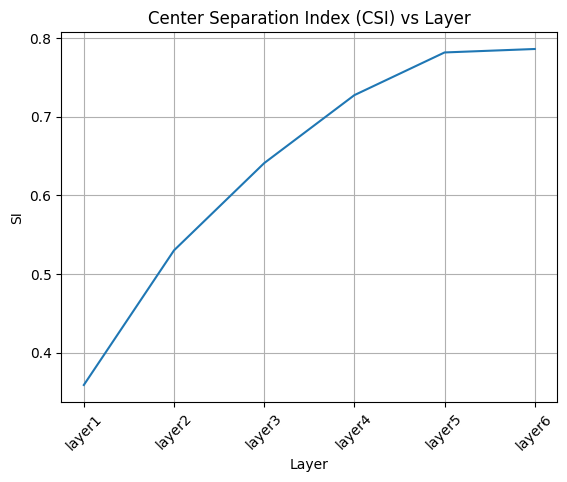

In [23]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    


print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# seventh Layer

In [24]:
import torch.nn as nn

class VGG11_seven_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_seven_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [25]:
import torch
import torch.nn as nn


model = VGG11_seven_layer().to(device)

# Define the paths to your weight files
weight_files = {
    'layer1': 'first_layer_freeze.pth',
    'layer2': 'second_layer_freeze.pth',
    'layer3': 'third_layer_freeze.pth',
    'layer4': 'fourth_layer_freeze.pth',
    'layer5': 'fifth_layer_freeze.pth',
    'layer6': 'sixth_layer_freeze.pth'

}

# Load and update the model's state dict for each layer
for layer_name, file_path in weight_files.items():
    pretrained_dict = torch.load(file_path)
    model_dict = model.state_dict()
    # Filter out FC layer weights and update the state dict for each layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)

# Freeze the first three layers
for layer in [model.layer1, model.layer2, model.layer3, model.layer4, model.layer5, model.layer6]:
    for param in layer.parameters():
        param.requires_grad = False

model

VGG11_seven_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [34]:
print_trainable_status(model)

VGG11_seven_layer.layer1: requires_grad=False
VGG11_seven_layer.layer1: requires_grad=False
VGG11_seven_layer.layer1: requires_grad=False
VGG11_seven_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_seven_layer.layer2: requires_grad=False
VGG11_seven_layer.layer2: requires_grad=False
VGG11_seven_layer.layer2: requires_grad=False
VGG11_seven_layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_seven_layer.layer3: requires_grad=False
VGG11_seven_layer.layer3: requires_grad=False
VGG11_seven_layer.layer3: requires_grad=False
VGG11_seven_layer.layer3: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_seven_laye

  7%|▋         | 1/15 [00:40<09:21, 40.08s/it]

Epoch [1/15], Step [352/352], Training Loss: 0.3912, Training Accuracy: 86.56%, Validation Accuracy: 80.28%, Validation Loss: 0.6324


 13%|█▎        | 2/15 [01:20<08:43, 40.30s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.3308, Training Accuracy: 88.26%, Validation Accuracy: 80.52%, Validation Loss: 0.6065


 20%|██        | 3/15 [02:00<08:04, 40.34s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.3137, Training Accuracy: 88.93%, Validation Accuracy: 81.02%, Validation Loss: 0.5751


 27%|██▋       | 4/15 [02:40<07:22, 40.21s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.3079, Training Accuracy: 89.06%, Validation Accuracy: 81.08%, Validation Loss: 0.5864


 33%|███▎      | 5/15 [03:20<06:40, 40.05s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.3087, Training Accuracy: 89.18%, Validation Accuracy: 81.24%, Validation Loss: 0.5698


 40%|████      | 6/15 [04:00<06:00, 40.03s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.2796, Training Accuracy: 90.26%, Validation Accuracy: 81.42%, Validation Loss: 0.5809


 47%|████▋     | 7/15 [04:40<05:20, 40.04s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.2735, Training Accuracy: 90.33%, Validation Accuracy: 81.22%, Validation Loss: 0.5898


 53%|█████▎    | 8/15 [05:21<04:41, 40.19s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2758, Training Accuracy: 90.37%, Validation Accuracy: 81.32%, Validation Loss: 0.5730


 60%|██████    | 9/15 [06:03<04:04, 40.71s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2713, Training Accuracy: 90.38%, Validation Accuracy: 81.08%, Validation Loss: 0.5620


 67%|██████▋   | 10/15 [06:42<03:21, 40.35s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.2686, Training Accuracy: 90.53%, Validation Accuracy: 81.22%, Validation Loss: 0.5963


 73%|███████▎  | 11/15 [07:22<02:40, 40.24s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2668, Training Accuracy: 90.51%, Validation Accuracy: 81.24%, Validation Loss: 0.5914


 80%|████████  | 12/15 [08:03<02:00, 40.29s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2694, Training Accuracy: 90.56%, Validation Accuracy: 80.96%, Validation Loss: 0.6058


 87%|████████▋ | 13/15 [08:43<01:20, 40.25s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2688, Training Accuracy: 90.51%, Validation Accuracy: 81.78%, Validation Loss: 0.5715


 93%|█████████▎| 14/15 [09:23<00:40, 40.26s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2704, Training Accuracy: 90.56%, Validation Accuracy: 81.28%, Validation Loss: 0.5811


100%|██████████| 15/15 [10:03<00:00, 40.22s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2635, Training Accuracy: 90.75%, Validation Accuracy: 81.06%, Validation Loss: 0.6030


Test Set Accuracy on Best Weights: 82.91%


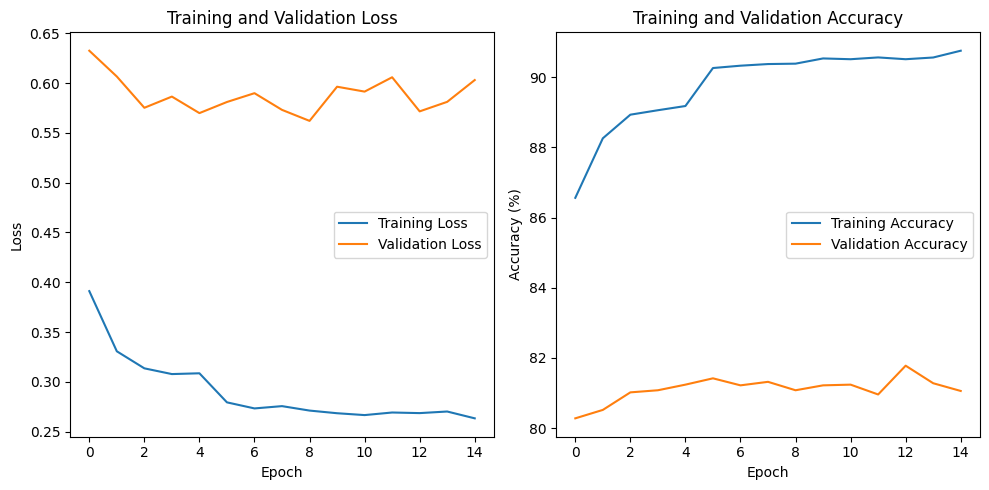

In [35]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'seventh_layer_freeze.pth' )

# Seventh Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 136.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3069.75it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2962.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3164.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3512.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3191.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3463.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1982.81it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3381.59it/s]


[('layer1', 0.3526666760444641), ('layer2', 0.5239999890327454), ('layer3', 0.6337777972221375), ('layer4', 0.7322222590446472), ('layer5', 0.7946666479110718), ('layer6', 0.8231111168861389), ('layer7', 0.8893333673477173), ('fc1', 0.8915555477142334), ('fc2', 0.879111111164093)]


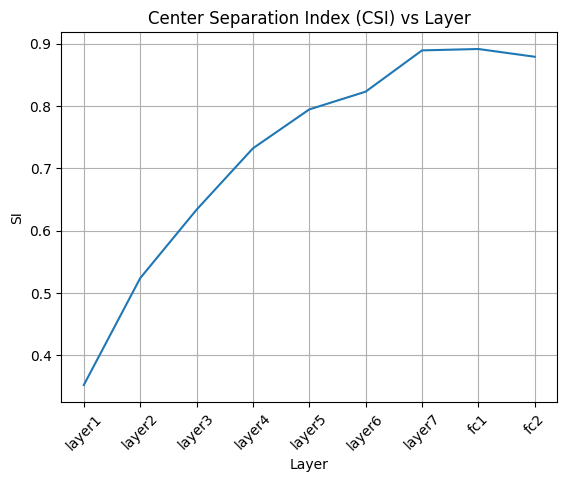

In [34]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.3526666760444641), ('layer2', 0.5239999890327454), ('layer3', 0.6337777972221375), ('layer4', 0.7322222590446472), ('layer5', 0.7946666479110718), ('layer6', 0.8231111168861389), ('layer7', 0.8893333673477173), ('fc1', 0.8915555477142334), ('fc2', 0.879111111164093)]


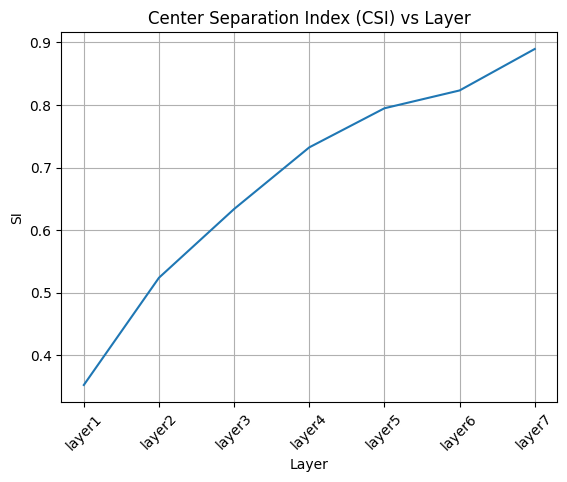

In [35]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Seventh Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 55.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4053.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4048.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4197.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4219.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4101.61it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4046.21it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4144.57it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4040.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4294.80it/s]


[('layer1', 0.3596999943256378), ('layer2', 0.529699981212616), ('layer3', 0.6412999629974365), ('layer4', 0.7287999987602234), ('layer5', 0.7827000021934509), ('layer6', 0.7882999777793884), ('layer7', 0.8227999806404114), ('fc1', 0.8247999548912048), ('fc2', 0.8140999674797058)]


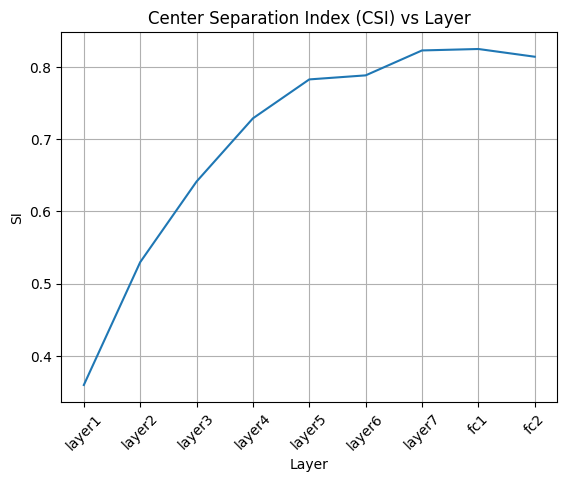

[('layer1', 0.3596999943256378), ('layer2', 0.529699981212616), ('layer3', 0.6412999629974365), ('layer4', 0.7287999987602234), ('layer5', 0.7827000021934509), ('layer6', 0.7882999777793884), ('layer7', 0.8227999806404114), ('fc1', 0.8247999548912048), ('fc2', 0.8140999674797058)]


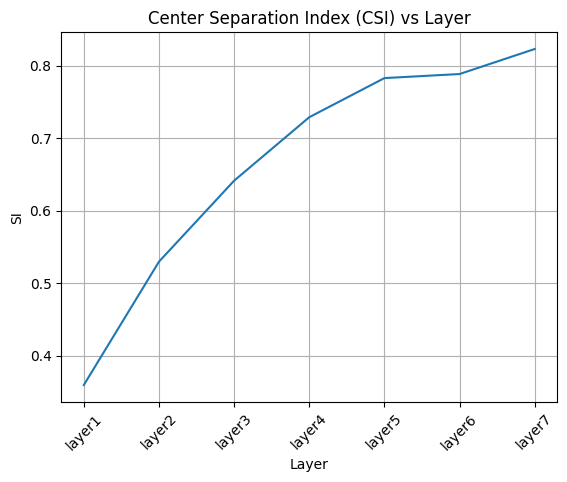

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()  

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer

In [27]:
import torch.nn as nn

class VGG11_eighth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_eighth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [28]:
import torch
import torch.nn as nn


model = VGG11_eighth_layer().to(device)

# Define the paths to your weight files
weight_files = {
    'layer1': 'first_layer_freeze.pth',
    'layer2': 'second_layer_freeze.pth',
    'layer3': 'third_layer_freeze.pth',
    'layer4': 'fourth_layer_freeze.pth',
    'layer5': 'fifth_layer_freeze.pth',
    'layer6': 'sixth_layer_freeze.pth',
    'layer7': 'seventh_layer_freeze.pth'


}

# Load and update the model's state dict for each layer
for layer_name, file_path in weight_files.items():
    pretrained_dict = torch.load(file_path)
    model_dict = model.state_dict()
    # Filter out FC layer weights and update the state dict for each layer
    filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}
    model_dict.update(filtered_dict)
    model.load_state_dict(model_dict)

# Freeze the first three layers
for layer in [model.layer1, model.layer2, model.layer3, model.layer4, model.layer5, model.layer6, model.layer7]:
    for param in layer.parameters():
        param.requires_grad = False

model

VGG11_eighth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [38]:
print_trainable_status(model)

VGG11_eighth_layer.layer1: requires_grad=False
VGG11_eighth_layer.layer1: requires_grad=False
VGG11_eighth_layer.layer1: requires_grad=False
VGG11_eighth_layer.layer1: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_eighth_layer.layer2: requires_grad=False
VGG11_eighth_layer.layer2: requires_grad=False
VGG11_eighth_layer.layer2: requires_grad=False
VGG11_eighth_layer.layer2: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG11_eighth_layer.layer3: requires_grad=False
VGG11_eighth_layer.layer3: requires_grad=False
VGG11_eighth_layer.layer3: requires_grad=False
VGG11_eighth_layer.layer3: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.0: requires_grad=False
  Sequential.1: requires_grad=False
  Sequential.1: requires_grad=False
VGG1

  7%|▋         | 1/15 [00:40<09:24, 40.30s/it]

Epoch [1/15], Step [352/352], Training Loss: 0.3362, Training Accuracy: 88.46%, Validation Accuracy: 81.76%, Validation Loss: 0.6024


 13%|█▎        | 2/15 [01:20<08:41, 40.12s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.3033, Training Accuracy: 89.40%, Validation Accuracy: 80.70%, Validation Loss: 0.6206


 20%|██        | 3/15 [02:00<08:02, 40.21s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.2980, Training Accuracy: 89.66%, Validation Accuracy: 81.18%, Validation Loss: 0.6132


 27%|██▋       | 4/15 [02:40<07:22, 40.23s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.2916, Training Accuracy: 89.79%, Validation Accuracy: 80.86%, Validation Loss: 0.5881


 33%|███▎      | 5/15 [03:21<06:43, 40.31s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.2866, Training Accuracy: 89.91%, Validation Accuracy: 80.38%, Validation Loss: 0.6091


 40%|████      | 6/15 [04:01<06:00, 40.10s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.2793, Training Accuracy: 90.20%, Validation Accuracy: 81.72%, Validation Loss: 0.5715


 47%|████▋     | 7/15 [04:41<05:20, 40.09s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.2740, Training Accuracy: 90.38%, Validation Accuracy: 81.14%, Validation Loss: 0.6041


 53%|█████▎    | 8/15 [05:21<04:40, 40.08s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2695, Training Accuracy: 90.48%, Validation Accuracy: 81.14%, Validation Loss: 0.5971


 60%|██████    | 9/15 [06:01<04:00, 40.16s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2692, Training Accuracy: 90.39%, Validation Accuracy: 81.68%, Validation Loss: 0.5711


 67%|██████▋   | 10/15 [06:41<03:20, 40.16s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.2759, Training Accuracy: 90.18%, Validation Accuracy: 82.04%, Validation Loss: 0.5620


 73%|███████▎  | 11/15 [07:21<02:40, 40.09s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2733, Training Accuracy: 90.28%, Validation Accuracy: 81.58%, Validation Loss: 0.5759


 80%|████████  | 12/15 [08:01<02:00, 40.09s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2688, Training Accuracy: 90.45%, Validation Accuracy: 81.04%, Validation Loss: 0.5891


 87%|████████▋ | 13/15 [08:41<01:20, 40.05s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.2704, Training Accuracy: 90.43%, Validation Accuracy: 81.48%, Validation Loss: 0.5905


 93%|█████████▎| 14/15 [09:22<00:40, 40.21s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.2660, Training Accuracy: 90.66%, Validation Accuracy: 80.88%, Validation Loss: 0.6166


100%|██████████| 15/15 [10:02<00:00, 40.19s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.2685, Training Accuracy: 90.57%, Validation Accuracy: 81.70%, Validation Loss: 0.5781


Test Set Accuracy on Best Weights: 83.00%


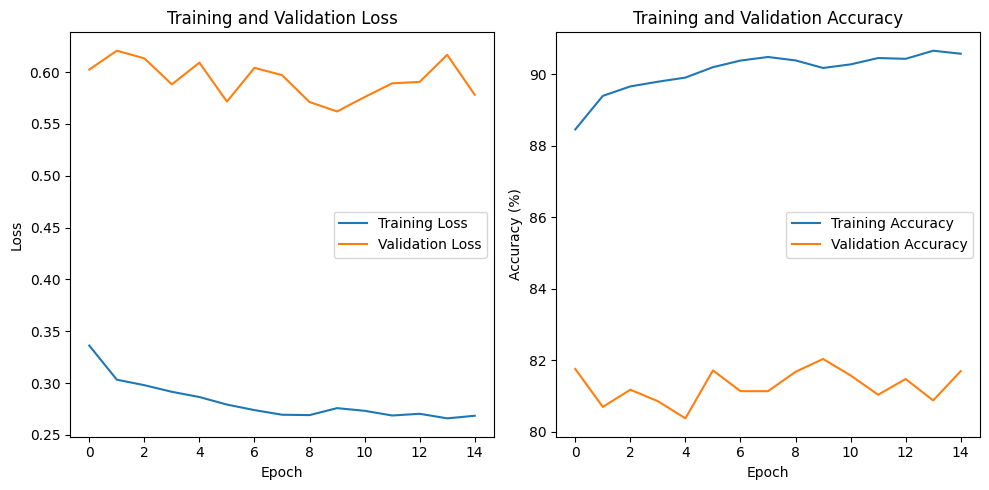

In [39]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0' ,  save_filename = 'eighth_layer_freeze.pth' )

# Eighth Layer CSI - train

100%|██████████| 36/36 [00:00<00:00, 199.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2806.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3107.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2854.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3078.76it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3243.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3161.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2270.87it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2379.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3416.48it/s]

[('layer1', 0.35333332419395447), ('layer2', 0.5237777829170227), ('layer3', 0.6322222352027893), ('layer4', 0.7315555810928345), ('layer5', 0.7948889136314392), ('layer6', 0.8240000009536743), ('layer7', 0.8882222175598145), ('layer8', 0.8773333430290222), ('fc1', 0.8953333497047424), ('fc2', 0.8911111354827881)]


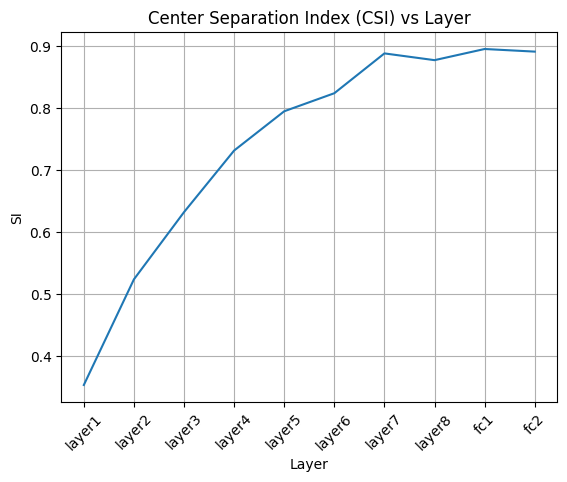

In [38]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.35333332419395447), ('layer2', 0.5237777829170227), ('layer3', 0.6322222352027893), ('layer4', 0.7315555810928345), ('layer5', 0.7948889136314392), ('layer6', 0.8240000009536743), ('layer7', 0.8882222175598145), ('layer8', 0.8773333430290222), ('fc1', 0.8953333497047424), ('fc2', 0.8911111354827881)]


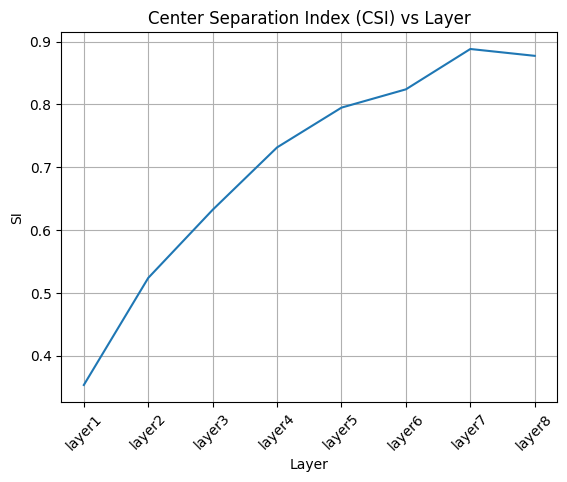

In [39]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 54.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4053.25it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4203.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4157.72it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4170.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4132.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3791.63it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4258.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4050.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4159.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4423.44it/s]

[('layer1', 0.35929998755455017), ('layer2', 0.5304999947547913), ('layer3', 0.6417999863624573), ('layer4', 0.7282999753952026), ('layer5', 0.7833999991416931), ('layer6', 0.7872999906539917), ('layer7', 0.8217999935150146), ('layer8', 0.809499979019165), ('fc1', 0.8244999647140503), ('fc2', 0.8223999738693237)]


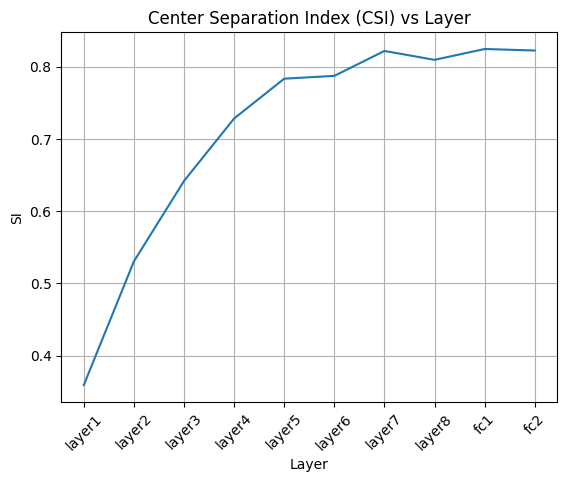

[('layer1', 0.35929998755455017), ('layer2', 0.5304999947547913), ('layer3', 0.6417999863624573), ('layer4', 0.7282999753952026), ('layer5', 0.7833999991416931), ('layer6', 0.7872999906539917), ('layer7', 0.8217999935150146), ('layer8', 0.809499979019165), ('fc1', 0.8244999647140503), ('fc2', 0.8223999738693237)]


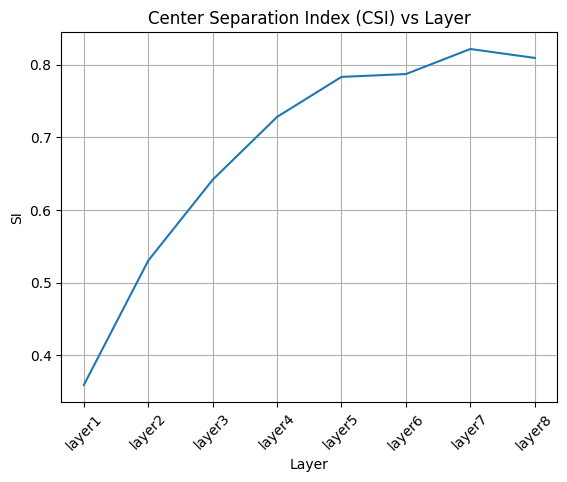

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_freeze.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()  

print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()